# Machine Translation with Transformers

Corpora: Tatoeba https://tatoeba.org/downloads and the Anki curated version: https://www.manythings.org/anki/

Authors: Maja Rygård and Alice Tottie and Pernilla Åström

In [4]:
import sys
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.utils.data import dataset
from torch.nn.utils.rnn import pad_sequence
import random
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import sentencepiece as spm
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics.functional import bleu_score

In [5]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

In [6]:
#!pip install -U 'numpy<2'

In [7]:
# if torch.cuda.is_available():
#    device = 'cuda'
# else:
#    device = 'cpu'
device = 'mps'
device = 'cpu'
DEVICE = torch.device(device)
DEVICE

device(type='cpu')

In [8]:
data_path = 'swe_eng.tsv'

In [9]:
data = open("swe_eng.tsv", "r").read()
data = data[1:]
lines = data.split("\n")

In [10]:
lines[:2]

['337413\tVi trodde att det var ett flygande tefat.\t248176\tWe believed it to be a flying saucer.',
 '341910\tDetta är huset jag bodde i när jag var barn.\t56221\tThis is the house where I lived when I was a child.']

In [11]:
input_texts = []
target_texts = []
for line in lines:
    if len(line.strip()) > 0:
        _, eng, _, swe = tuple(line.split("\t"))
        input_texts.append(eng)
        target_texts.append(swe)

In [12]:
# num_samples = 5000
# input_texts = []
# target_texts = []

# with open(data_path, "r", encoding="utf-8") as f:
#    lines = f.readlines()

# for line in lines[: min(num_samples, len(lines) - 1)]:
#    input_text, target_text, _ = line.strip().split("\t")
#    input_texts.append(input_text)
#    target_texts.append(target_text)

# print(input_texts)
# print(target_texts)

with open("all_texts.txt", "w", encoding='utf-8') as f:
    for input_text, target_text in zip(input_texts, target_texts):
        f.write(input_text + '\n')
        f.write(target_text + '\n')

In [13]:
print(input_texts[500])

print(target_texts[500])

Där såg han det han hade drömt om.
He saw there what he had dreamed about.


In [14]:
num_samples = len(input_texts)

In [15]:
TRAIN_PERCENTAGE = 0.8
train_val = int(TRAIN_PERCENTAGE * num_samples)
train_val

32430

In [16]:
text_pairs = list(zip(input_texts, target_texts))
random.shuffle(text_pairs)
input_texts, target_texts = zip(*text_pairs)
input_texts, target_texts = list(input_texts), list(target_texts)

In [17]:
train_input_texts = input_texts[:train_val]
train_target_texts = target_texts[:train_val]

val_input_texts = input_texts[train_val:]
val_target_texts = target_texts[train_val:]

In [19]:
# Running in a notebook hangs the cell. Run it from an external program
# spm.SentencePieceTrainer.train('--input=all_texts.txt --model_prefix=m --vocab_size=13700 --model_type=bpe --pad_id=3,logstream=sys.stdout')

In [20]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

sp.SetEncodeExtraOptions("bos:eos")
sp.SetDecodeExtraOptions("bos:eos")

True

In [21]:
UNK_IDX, BOS_IDX, EOS_IDX, PAD_IDX = 0, 1, 2, 3

In [22]:
def text2codes(texts, sp):
    codes = []
    for text in texts:
        code = sp.encode_as_ids(text)
        codes.append(torch.tensor(code))

    return codes

In [23]:
train_input_texts[:3], train_target_texts[:3]

(['Du är en bra ledare.',
  'Jag är rädd att jag inte kan göra mig förstådd på franska.',
  'Säg mig vad jag ska tänka.'],
 ["You're a good leader.",
  "I'm afraid I won't be able to make myself understood in French.",
  'Tell me what to think.'])

In [24]:
text2codes(train_input_texts, sp)[:3]

[tensor([    1,   206,    47,    72,   498, 11489, 13645,     2]),
 tensor([    1,    43,    47,  1368,    63,   127,    66,   189,   317,   137,
           555,  1300, 13644,    95,   945, 13645,     2]),
 tensor([    1,  2302,   137,   442,   127,   352,  3192, 13645,     2])]

In [25]:
text2codes(train_target_texts, sp)[:3]

[tensor([    1,   163, 13664,    52,    11,   514, 10316, 13645,     2]),
 tensor([    1,    22, 13664, 13647,  1796,    22,   690, 13664, 13637,    93,
          2097,    53,   775,  1961,  5465,    38,   819, 13645,     2]),
 tensor([    1,  2096,   131,   410,    53,   401, 13645,     2])]

In [26]:
def codes2text(codes, sp):
    texts = []
    for code in codes:
        text = sp.decode_ids(code.tolist())
        texts.append(text)
    return texts

In [27]:
codes2text(text2codes(train_input_texts, sp)[:3], sp)

['Du är en bra ledare.',
 'Jag är rädd att jag inte kan göra mig förstådd på franska.',
 'Säg mig vad jag ska tänka.']

In [28]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)
                        * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)
        self.emb_size = emb_size

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding * math.sqrt(self.emb_size)
                            + self.pos_embedding[:token_embedding.size(0), :])

In [29]:
pe = PositionalEncoding(10, 0.1)

In [30]:
torch.zeros(1, 5, 10)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [31]:
pe(torch.zeros(1, 5, 10))

tensor([[[0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 0.0000],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 0.0000, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111]]])

In [32]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super().__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)

        self.emb_size = emb_size
        self.embedding = nn.Embedding(
            vocab_size, emb_size, padding_idx=PAD_IDX)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

        self.generator = nn.Linear(emb_size, vocab_size, bias=False)
        self.generator.weight = self.embedding.weight

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.embedding(src))
        tgt_emb = self.positional_encoding(self.embedding(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
            self.embedding(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
            self.embedding(tgt)), memory,
            tgt_mask)

In [33]:
nn.Transformer.generate_square_subsequent_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [34]:
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),
                           device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1).type(torch.float32)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [35]:
src = pad_sequence(text2codes(
    train_input_texts[:3], sp), padding_value=PAD_IDX)
tgt = pad_sequence(text2codes(
    train_target_texts[:3], sp), padding_value=PAD_IDX)

In [36]:
train_input_texts[:3], train_target_texts[:3]

(['Du är en bra ledare.',
  'Jag är rädd att jag inte kan göra mig förstådd på franska.',
  'Säg mig vad jag ska tänka.'],
 ["You're a good leader.",
  "I'm afraid I won't be able to make myself understood in French.",
  'Tell me what to think.'])

In [37]:
src

tensor([[    1,     1,     1],
        [  206,    43,  2302],
        [   47,    47,   137],
        [   72,  1368,   442],
        [  498,    63,   127],
        [11489,   127,   352],
        [13645,    66,  3192],
        [    2,   189, 13645],
        [    3,   317,     2],
        [    3,   137,     3],
        [    3,   555,     3],
        [    3,  1300,     3],
        [    3, 13644,     3],
        [    3,    95,     3],
        [    3,   945,     3],
        [    3, 13645,     3],
        [    3,     2,     3]])

In [38]:
tgt

tensor([[    1,     1,     1],
        [  163,    22,  2096],
        [13664, 13664,   131],
        [   52, 13647,   410],
        [   11,  1796,    53],
        [  514,    22,   401],
        [10316,   690, 13645],
        [13645, 13664,     2],
        [    2, 13637,     3],
        [    3,    93,     3],
        [    3,  2097,     3],
        [    3,    53,     3],
        [    3,   775,     3],
        [    3,  1961,     3],
        [    3,  5465,     3],
        [    3,    38,     3],
        [    3,   819,     3],
        [    3, 13645,     3],
        [    3,     2,     3]])

In [39]:
create_mask(src, tgt)

(tensor([[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False],
         [False, Fal

In [40]:
VOCAB_SIZE = 13700
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6

In [41]:
def rate(step, model_size, factor, warmup):
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [42]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.1)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-6
)
lr_scheduler = LambdaLR(
    optimizer=optimizer,
    lr_lambda=lambda step: rate(
        step, model_size=transformer.emb_size, factor=0.25, warmup=4000
    ),
)

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


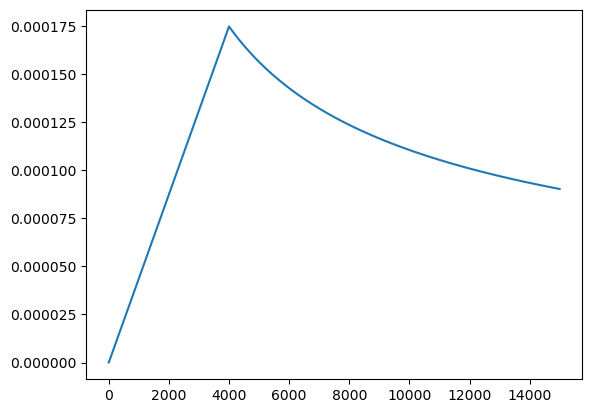

In [43]:
plt.plot([rate(i, transformer.emb_size, 0.25, 4000)
         for i in range(0, 15*1000)])

In [44]:
class PairDataset(Dataset):
    def __init__(self, input_texts, target_texts, token2idx):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.token2idx = token2idx

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        src_batch = text2codes([input_texts[idx]], self.token2idx)
        tgt_batch = text2codes([target_texts[idx]], self.token2idx)

        return src_batch[0], tgt_batch[0]

    def collate(self, batch):
        src_batch, tgt_batch = list(zip(*batch))
        src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
        tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)

        return src_batch, tgt_batch

In [45]:
train_dataset = PairDataset(train_input_texts, train_target_texts, sp)
train_dataloader = DataLoader(train_dataset, batch_size=32,
                              shuffle=True, collate_fn=train_dataset.collate)

In [46]:
val_dataset = PairDataset(val_input_texts, val_target_texts, sp)
val_dataloader = DataLoader(
    val_dataset, batch_size=32, collate_fn=val_dataset.collate)

In [47]:
def train_epoch(model, optimizer, dataloader):
    model.train()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0
    for src_batch, tgt_batch in tqdm(dataloader):
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src,
                       tgt_input,
                       src_mask,
                       tgt_mask,
                       src_padding_mask,
                       tgt_padding_mask,
                       src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

        if torch.isnan(loss):
            print("N_logits(NaN) == %d" % torch.sum(
                torch.isnan(logits.reshape(-1, logits.shape[-1]))))
            raise ValueError("loss is nan")

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        losses += loss.item()

        with torch.no_grad():
            sent_cnt += tgt_out.size()[-1]

            total += torch.numel(tgt_input)
            _, char_pred = torch.max(logits, -1)
            correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total

In [48]:
def evaluate(model, dataloader):
    model.eval()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0

    for src_batch, tgt_batch in dataloader:
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                       src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        sent_cnt += tgt_out.size()[-1]

        total += torch.numel(tgt_input)
        _, char_pred = torch.max(logits, -1)
        correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total

In [49]:
from timeit import default_timer as timer
NUM_EPOCHS = 80
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss, train_acc = train_epoch(
        transformer, optimizer, train_dataloader)
    train_losses += [train_loss]
    train_accs += [train_acc]
    end_time = timer()
    val_loss, val_acc = evaluate(transformer, val_dataloader)
    val_losses += [val_loss]
    val_accs += [val_acc]
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Train acc.: {train_acc:.3f}, Val acc.: {val_acc:.3f}, Epoch time = {(end_time - start_time):.3f}s"))

100%|██████████| 1014/1014 [05:12<00:00,  3.24it/s]


Epoch: 1, Train loss: 0.217, Val loss: 0.166, Train acc.: 0.091, Val acc.: 0.156, Epoch time = 312.585s


100%|██████████| 1014/1014 [05:01<00:00,  3.37it/s]


Epoch: 2, Train loss: 0.155, Val loss: 0.141, Train acc.: 0.175, Val acc.: 0.209, Epoch time = 301.262s


100%|██████████| 1014/1014 [04:59<00:00,  3.38it/s]


Epoch: 3, Train loss: 0.137, Val loss: 0.127, Train acc.: 0.209, Val acc.: 0.238, Epoch time = 299.666s


100%|██████████| 1014/1014 [05:00<00:00,  3.37it/s]


Epoch: 4, Train loss: 0.126, Val loss: 0.116, Train acc.: 0.229, Val acc.: 0.256, Epoch time = 300.474s


100%|██████████| 1014/1014 [05:02<00:00,  3.35it/s]


Epoch: 5, Train loss: 0.117, Val loss: 0.107, Train acc.: 0.243, Val acc.: 0.276, Epoch time = 302.266s


100%|██████████| 1014/1014 [04:57<00:00,  3.41it/s]


Epoch: 6, Train loss: 0.109, Val loss: 0.099, Train acc.: 0.261, Val acc.: 0.297, Epoch time = 297.545s


100%|██████████| 1014/1014 [04:47<00:00,  3.52it/s]


Epoch: 7, Train loss: 0.102, Val loss: 0.092, Train acc.: 0.278, Val acc.: 0.314, Epoch time = 287.761s


100%|██████████| 1014/1014 [04:46<00:00,  3.54it/s]


Epoch: 8, Train loss: 0.096, Val loss: 0.087, Train acc.: 0.292, Val acc.: 0.330, Epoch time = 286.329s


100%|██████████| 1014/1014 [04:47<00:00,  3.53it/s]


Epoch: 9, Train loss: 0.091, Val loss: 0.082, Train acc.: 0.305, Val acc.: 0.342, Epoch time = 287.090s


100%|██████████| 1014/1014 [04:51<00:00,  3.48it/s]


Epoch: 10, Train loss: 0.087, Val loss: 0.079, Train acc.: 0.315, Val acc.: 0.352, Epoch time = 291.454s


100%|██████████| 1014/1014 [04:51<00:00,  3.48it/s]


Epoch: 11, Train loss: 0.084, Val loss: 0.076, Train acc.: 0.323, Val acc.: 0.360, Epoch time = 291.713s


100%|██████████| 1014/1014 [04:51<00:00,  3.48it/s]


Epoch: 12, Train loss: 0.082, Val loss: 0.074, Train acc.: 0.328, Val acc.: 0.366, Epoch time = 291.401s


100%|██████████| 1014/1014 [04:50<00:00,  3.49it/s]


Epoch: 13, Train loss: 0.079, Val loss: 0.071, Train acc.: 0.335, Val acc.: 0.374, Epoch time = 290.794s


100%|██████████| 1014/1014 [04:53<00:00,  3.45it/s]


Epoch: 14, Train loss: 0.077, Val loss: 0.069, Train acc.: 0.340, Val acc.: 0.379, Epoch time = 293.711s


100%|██████████| 1014/1014 [04:50<00:00,  3.49it/s]


Epoch: 15, Train loss: 0.075, Val loss: 0.068, Train acc.: 0.348, Val acc.: 0.383, Epoch time = 290.744s


100%|██████████| 1014/1014 [04:53<00:00,  3.46it/s]


Epoch: 16, Train loss: 0.074, Val loss: 0.066, Train acc.: 0.348, Val acc.: 0.388, Epoch time = 293.476s


100%|██████████| 1014/1014 [04:58<00:00,  3.39it/s]


Epoch: 17, Train loss: 0.072, Val loss: 0.065, Train acc.: 0.354, Val acc.: 0.393, Epoch time = 298.918s


100%|██████████| 1014/1014 [04:59<00:00,  3.38it/s]


Epoch: 18, Train loss: 0.071, Val loss: 0.064, Train acc.: 0.357, Val acc.: 0.396, Epoch time = 299.610s


100%|██████████| 1014/1014 [05:00<00:00,  3.37it/s]


Epoch: 19, Train loss: 0.070, Val loss: 0.063, Train acc.: 0.361, Val acc.: 0.399, Epoch time = 300.862s


100%|██████████| 1014/1014 [04:49<00:00,  3.50it/s]


Epoch: 20, Train loss: 0.069, Val loss: 0.061, Train acc.: 0.367, Val acc.: 0.402, Epoch time = 289.540s


100%|██████████| 1014/1014 [04:49<00:00,  3.50it/s]


Epoch: 21, Train loss: 0.068, Val loss: 0.061, Train acc.: 0.368, Val acc.: 0.405, Epoch time = 289.582s


100%|██████████| 1014/1014 [04:52<00:00,  3.46it/s]


Epoch: 22, Train loss: 0.067, Val loss: 0.060, Train acc.: 0.370, Val acc.: 0.409, Epoch time = 292.665s


100%|██████████| 1014/1014 [04:47<00:00,  3.52it/s]


Epoch: 23, Train loss: 0.066, Val loss: 0.059, Train acc.: 0.371, Val acc.: 0.411, Epoch time = 287.945s


100%|██████████| 1014/1014 [04:46<00:00,  3.54it/s]


Epoch: 24, Train loss: 0.065, Val loss: 0.058, Train acc.: 0.375, Val acc.: 0.414, Epoch time = 286.765s


100%|██████████| 1014/1014 [04:47<00:00,  3.53it/s]


Epoch: 25, Train loss: 0.064, Val loss: 0.057, Train acc.: 0.379, Val acc.: 0.416, Epoch time = 287.562s


100%|██████████| 1014/1014 [04:45<00:00,  3.55it/s]


Epoch: 26, Train loss: 0.063, Val loss: 0.057, Train acc.: 0.379, Val acc.: 0.418, Epoch time = 285.271s


100%|██████████| 1014/1014 [04:45<00:00,  3.56it/s]


Epoch: 27, Train loss: 0.063, Val loss: 0.056, Train acc.: 0.381, Val acc.: 0.420, Epoch time = 285.096s


100%|██████████| 1014/1014 [04:44<00:00,  3.57it/s]


Epoch: 28, Train loss: 0.062, Val loss: 0.056, Train acc.: 0.388, Val acc.: 0.422, Epoch time = 284.149s


100%|██████████| 1014/1014 [04:44<00:00,  3.57it/s]


Epoch: 29, Train loss: 0.061, Val loss: 0.055, Train acc.: 0.383, Val acc.: 0.424, Epoch time = 284.350s


100%|██████████| 1014/1014 [04:41<00:00,  3.61it/s]


Epoch: 30, Train loss: 0.061, Val loss: 0.055, Train acc.: 0.388, Val acc.: 0.425, Epoch time = 281.152s


100%|██████████| 1014/1014 [04:42<00:00,  3.59it/s]


Epoch: 31, Train loss: 0.060, Val loss: 0.054, Train acc.: 0.389, Val acc.: 0.427, Epoch time = 282.365s


100%|██████████| 1014/1014 [04:41<00:00,  3.61it/s]


Epoch: 32, Train loss: 0.060, Val loss: 0.054, Train acc.: 0.390, Val acc.: 0.428, Epoch time = 281.148s


100%|██████████| 1014/1014 [04:42<00:00,  3.59it/s]


Epoch: 33, Train loss: 0.059, Val loss: 0.053, Train acc.: 0.394, Val acc.: 0.429, Epoch time = 282.349s


100%|██████████| 1014/1014 [04:43<00:00,  3.57it/s]


Epoch: 34, Train loss: 0.058, Val loss: 0.053, Train acc.: 0.393, Val acc.: 0.431, Epoch time = 283.793s


100%|██████████| 1014/1014 [04:44<00:00,  3.57it/s]


Epoch: 35, Train loss: 0.058, Val loss: 0.052, Train acc.: 0.395, Val acc.: 0.432, Epoch time = 284.053s


100%|██████████| 1014/1014 [04:43<00:00,  3.58it/s]


Epoch: 36, Train loss: 0.058, Val loss: 0.052, Train acc.: 0.398, Val acc.: 0.434, Epoch time = 283.493s


100%|██████████| 1014/1014 [04:44<00:00,  3.57it/s]


Epoch: 37, Train loss: 0.057, Val loss: 0.052, Train acc.: 0.399, Val acc.: 0.435, Epoch time = 284.116s


100%|██████████| 1014/1014 [04:44<00:00,  3.56it/s]


Epoch: 38, Train loss: 0.057, Val loss: 0.051, Train acc.: 0.397, Val acc.: 0.436, Epoch time = 284.444s


100%|██████████| 1014/1014 [04:45<00:00,  3.55it/s]


Epoch: 39, Train loss: 0.056, Val loss: 0.051, Train acc.: 0.399, Val acc.: 0.436, Epoch time = 285.858s


100%|██████████| 1014/1014 [04:46<00:00,  3.54it/s]


Epoch: 40, Train loss: 0.056, Val loss: 0.051, Train acc.: 0.402, Val acc.: 0.438, Epoch time = 286.141s


100%|██████████| 1014/1014 [04:45<00:00,  3.55it/s]


Epoch: 41, Train loss: 0.056, Val loss: 0.051, Train acc.: 0.401, Val acc.: 0.438, Epoch time = 285.942s


100%|██████████| 1014/1014 [04:44<00:00,  3.57it/s]


Epoch: 42, Train loss: 0.055, Val loss: 0.050, Train acc.: 0.404, Val acc.: 0.439, Epoch time = 284.291s


100%|██████████| 1014/1014 [04:43<00:00,  3.58it/s]


Epoch: 43, Train loss: 0.055, Val loss: 0.050, Train acc.: 0.405, Val acc.: 0.440, Epoch time = 283.403s


100%|██████████| 1014/1014 [04:46<00:00,  3.53it/s]


Epoch: 44, Train loss: 0.055, Val loss: 0.050, Train acc.: 0.404, Val acc.: 0.440, Epoch time = 286.985s


100%|██████████| 1014/1014 [04:44<00:00,  3.56it/s]


Epoch: 45, Train loss: 0.054, Val loss: 0.050, Train acc.: 0.404, Val acc.: 0.441, Epoch time = 284.751s


100%|██████████| 1014/1014 [04:45<00:00,  3.56it/s]


Epoch: 46, Train loss: 0.054, Val loss: 0.050, Train acc.: 0.406, Val acc.: 0.441, Epoch time = 285.132s


100%|██████████| 1014/1014 [04:45<00:00,  3.55it/s]


Epoch: 47, Train loss: 0.054, Val loss: 0.049, Train acc.: 0.408, Val acc.: 0.442, Epoch time = 285.459s


100%|██████████| 1014/1014 [04:44<00:00,  3.56it/s]


Epoch: 48, Train loss: 0.054, Val loss: 0.049, Train acc.: 0.409, Val acc.: 0.442, Epoch time = 284.549s


100%|██████████| 1014/1014 [04:46<00:00,  3.54it/s]


Epoch: 49, Train loss: 0.053, Val loss: 0.049, Train acc.: 0.408, Val acc.: 0.443, Epoch time = 286.826s


100%|██████████| 1014/1014 [04:45<00:00,  3.55it/s]


Epoch: 50, Train loss: 0.053, Val loss: 0.049, Train acc.: 0.410, Val acc.: 0.443, Epoch time = 285.370s


100%|██████████| 1014/1014 [04:44<00:00,  3.56it/s]


Epoch: 51, Train loss: 0.053, Val loss: 0.049, Train acc.: 0.412, Val acc.: 0.443, Epoch time = 284.450s


100%|██████████| 1014/1014 [04:45<00:00,  3.55it/s]


Epoch: 52, Train loss: 0.053, Val loss: 0.049, Train acc.: 0.412, Val acc.: 0.444, Epoch time = 285.355s


100%|██████████| 1014/1014 [04:41<00:00,  3.60it/s]


Epoch: 53, Train loss: 0.053, Val loss: 0.049, Train acc.: 0.414, Val acc.: 0.444, Epoch time = 281.825s


100%|██████████| 1014/1014 [04:43<00:00,  3.58it/s]


Epoch: 54, Train loss: 0.052, Val loss: 0.049, Train acc.: 0.414, Val acc.: 0.444, Epoch time = 283.285s


100%|██████████| 1014/1014 [04:42<00:00,  3.58it/s]


Epoch: 55, Train loss: 0.052, Val loss: 0.049, Train acc.: 0.413, Val acc.: 0.445, Epoch time = 282.938s


100%|██████████| 1014/1014 [04:43<00:00,  3.58it/s]


Epoch: 56, Train loss: 0.052, Val loss: 0.049, Train acc.: 0.414, Val acc.: 0.445, Epoch time = 283.384s


100%|██████████| 1014/1014 [04:42<00:00,  3.59it/s]


Epoch: 57, Train loss: 0.052, Val loss: 0.048, Train acc.: 0.415, Val acc.: 0.445, Epoch time = 282.230s


100%|██████████| 1014/1014 [04:45<00:00,  3.55it/s]


Epoch: 58, Train loss: 0.052, Val loss: 0.048, Train acc.: 0.416, Val acc.: 0.445, Epoch time = 285.546s


100%|██████████| 1014/1014 [04:43<00:00,  3.58it/s]


Epoch: 59, Train loss: 0.052, Val loss: 0.048, Train acc.: 0.414, Val acc.: 0.446, Epoch time = 283.261s


100%|██████████| 1014/1014 [04:43<00:00,  3.58it/s]


Epoch: 60, Train loss: 0.052, Val loss: 0.048, Train acc.: 0.415, Val acc.: 0.446, Epoch time = 283.399s


100%|██████████| 1014/1014 [04:42<00:00,  3.59it/s]


Epoch: 61, Train loss: 0.051, Val loss: 0.048, Train acc.: 0.417, Val acc.: 0.446, Epoch time = 282.352s


100%|██████████| 1014/1014 [04:42<00:00,  3.59it/s]


Epoch: 62, Train loss: 0.051, Val loss: 0.048, Train acc.: 0.418, Val acc.: 0.446, Epoch time = 282.492s


100%|██████████| 1014/1014 [04:43<00:00,  3.58it/s]


Epoch: 63, Train loss: 0.051, Val loss: 0.048, Train acc.: 0.415, Val acc.: 0.447, Epoch time = 283.474s


100%|██████████| 1014/1014 [04:42<00:00,  3.59it/s]


Epoch: 64, Train loss: 0.051, Val loss: 0.048, Train acc.: 0.419, Val acc.: 0.447, Epoch time = 282.336s


100%|██████████| 1014/1014 [04:43<00:00,  3.58it/s]


Epoch: 65, Train loss: 0.051, Val loss: 0.048, Train acc.: 0.418, Val acc.: 0.447, Epoch time = 283.455s


100%|██████████| 1014/1014 [04:44<00:00,  3.56it/s]


Epoch: 66, Train loss: 0.051, Val loss: 0.048, Train acc.: 0.419, Val acc.: 0.447, Epoch time = 284.637s


100%|██████████| 1014/1014 [04:46<00:00,  3.54it/s]


Epoch: 67, Train loss: 0.051, Val loss: 0.048, Train acc.: 0.419, Val acc.: 0.447, Epoch time = 286.122s


100%|██████████| 1014/1014 [04:47<00:00,  3.52it/s]


Epoch: 68, Train loss: 0.050, Val loss: 0.048, Train acc.: 0.417, Val acc.: 0.448, Epoch time = 287.792s


100%|██████████| 1014/1014 [04:44<00:00,  3.57it/s]


Epoch: 69, Train loss: 0.050, Val loss: 0.047, Train acc.: 0.420, Val acc.: 0.448, Epoch time = 284.405s


100%|██████████| 1014/1014 [04:46<00:00,  3.54it/s]


Epoch: 70, Train loss: 0.050, Val loss: 0.047, Train acc.: 0.421, Val acc.: 0.448, Epoch time = 286.653s


100%|██████████| 1014/1014 [04:43<00:00,  3.58it/s]


Epoch: 71, Train loss: 0.050, Val loss: 0.047, Train acc.: 0.420, Val acc.: 0.448, Epoch time = 283.251s


100%|██████████| 1014/1014 [04:43<00:00,  3.58it/s]


Epoch: 72, Train loss: 0.050, Val loss: 0.047, Train acc.: 0.419, Val acc.: 0.448, Epoch time = 283.547s


100%|██████████| 1014/1014 [04:42<00:00,  3.59it/s]


Epoch: 73, Train loss: 0.050, Val loss: 0.047, Train acc.: 0.420, Val acc.: 0.448, Epoch time = 282.717s


100%|██████████| 1014/1014 [04:43<00:00,  3.58it/s]


Epoch: 74, Train loss: 0.050, Val loss: 0.047, Train acc.: 0.420, Val acc.: 0.449, Epoch time = 283.184s


100%|██████████| 1014/1014 [04:42<00:00,  3.59it/s]


Epoch: 75, Train loss: 0.050, Val loss: 0.047, Train acc.: 0.422, Val acc.: 0.449, Epoch time = 282.175s


100%|██████████| 1014/1014 [04:44<00:00,  3.57it/s]


Epoch: 76, Train loss: 0.050, Val loss: 0.047, Train acc.: 0.422, Val acc.: 0.449, Epoch time = 284.211s


100%|██████████| 1014/1014 [04:46<00:00,  3.54it/s]


Epoch: 77, Train loss: 0.050, Val loss: 0.047, Train acc.: 0.424, Val acc.: 0.449, Epoch time = 286.228s


100%|██████████| 1014/1014 [04:49<00:00,  3.50it/s]


Epoch: 78, Train loss: 0.049, Val loss: 0.047, Train acc.: 0.423, Val acc.: 0.449, Epoch time = 289.642s


100%|██████████| 1014/1014 [04:45<00:00,  3.56it/s]


Epoch: 79, Train loss: 0.049, Val loss: 0.047, Train acc.: 0.423, Val acc.: 0.449, Epoch time = 285.219s


100%|██████████| 1014/1014 [04:46<00:00,  3.54it/s]


Epoch: 80, Train loss: 0.049, Val loss: 0.047, Train acc.: 0.423, Val acc.: 0.449, Epoch time = 286.491s


In [50]:
torch.save(transformer, 'model_tateoba.pth')

In [51]:
epochs = range(NUM_EPOCHS)

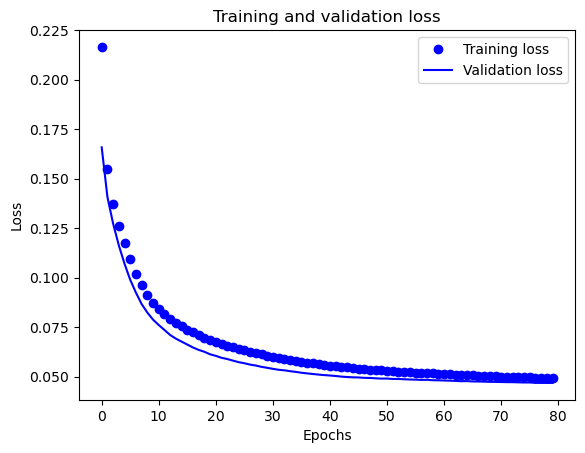

In [52]:
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

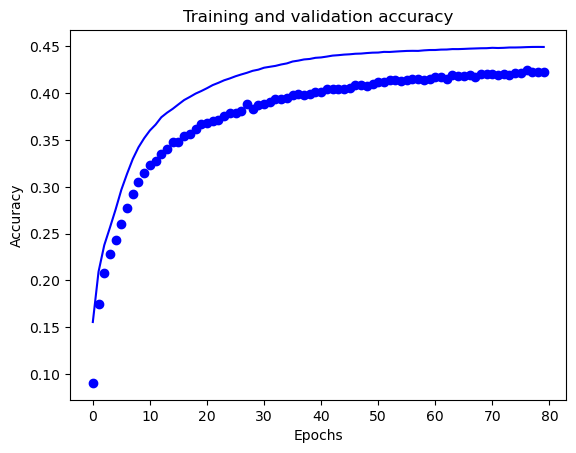

In [53]:
plt.plot(epochs, train_accs, 'bo', label='Training acc')
plt.plot(epochs, val_accs, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [54]:
def beam_search_decode(model, src, src_mask, max_len, start_symbol, beam_size=5):
    # DEVICE = src.device
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)

    beam = [(ys, 0)]

    for _ in range(max_len-1):
        candidates = []

        for ys, score in beam:
            ys = ys.to(DEVICE)
            memory = memory.to(DEVICE)
            tgt_mask = (nn.Transformer.generate_square_subsequent_mask(ys.size(0))
                        .type(torch.bool)).to(DEVICE)
            out = model.decode(ys, memory, tgt_mask)
            out = out.transpose(0, 1)
            prob = model.generator(out[:, -1])
            topk_probs, topk_words = torch.topk(prob, beam_size, dim=1)

            for i in range(beam_size):
                next_word = topk_words[0][i].item()
                new_score = score + topk_probs[0][i].item()
                new_ys = torch.cat(
                    [ys, torch.tensor([[next_word]], device=DEVICE)], dim=0)
                candidates.append((new_ys, new_score))

        beam = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_size]

        end_flag = all([torch.eq(candidate[0][-1], EOS_IDX)
                       for candidate, _ in beam])
        if end_flag:
            break

    best_candidate = max(beam, key=lambda x: x[1])

    return best_candidate[0]

In [ ]:
# WHEN NOT USING BEAM SEARCH, USE THIS CODE BELOW INSTEAD

# def greedy_decode(model, src, src_mask, max_len, start_symbol):
#     src = src.to(DEVICE)
#     src_mask = src_mask.to(DEVICE)

#     memory = model.encode(src, src_mask)
#     ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
#     # print(ys)
#     for i in range(max_len-1):
#         memory = memory.to(DEVICE)
#         tgt_mask = (generate_square_subsequent_mask(ys.size(0))
#                     .type(torch.bool)).to(DEVICE)
#         out = model.decode(ys, memory, tgt_mask)
#         out = out.transpose(0, 1)
#         prob = model.generator(out[:, -1])
#         _, next_word = torch.max(prob, dim=1)
#         next_word = next_word.item()

#         ys = torch.cat([ys,
#                         torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
#         # print(ys) # Remove the comment to understand the loop
#         if next_word == 2:
#             break
#     return ys

In [55]:
text2codes(['Go!'], sp)[0].view(-1, 1)

tensor([[    1],
        [ 1565],
        [13675],
        [    2]])

In [56]:
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text2codes([src_sentence], sp)[0].view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

    tgt_tokens = beam_search_decode(
        model, src, src_mask, max_len=num_tokens + 20, start_symbol=BOS_IDX, beam_size=3).flatten()

    tgt_chars_specials = codes2text([tgt_tokens], sp)
    tgt_words = []
    for token in tgt_chars_specials:
        if token not in ['<s>', '</s>', '<unk>']:
            tgt_words.append(token.strip())
    tgt_sentence = ' '.join(tgt_words)
    return tgt_sentence

In [58]:
tgt_sent = translate(transformer, 'Jag dricker vatten varje dag')
tgt_sent

'I drink water every day.'

In [59]:
tgt_sent = translate(transformer, 'Kan du översätta en enkel mening?')
tgt_sent

'Can you translate a second sentence?'

In [60]:
tgt_sent = translate(transformer, 'Vad heter du?')
tgt_sent

"What's your name?"

In [73]:
swe = ["Jag bor i ett stort rött hus.", "Solen är väldigt stor och varm.", "Idag är det väldigt kallt och blåsigt!", "Vill du ha salt till din pasta?", "Du behöver glasögon, för du kan inte se.",
       "Min hund är är åtta år gammal.", "Jag har på mig byxor och en tröja.", "Det är en eld i byggnaden!", "Gillar du att plugga på din dator?", "Bussen var väldigt full idag."]
eng = ["I live in a big red house.", "The sun is very big and hot.", "Today it's very cold and windy!", "Would you like to have some salt for your pasta?", "You need glasses, because you can't see.",
       "My dog is eigth years old.", "I'm wearing pants and a shirt.", "It is a fire in the building!", "Do you like to study on your computer?", "The bus was very full today."]

In [77]:
cand = []
for sent in swe:
    cand.append(translate(transformer, sent))
cand

['I live in a big house. a large house.',
 'The sun is very large and warm.',
 'Today is very cold and cold!!',
 'Do you want to salt for your pasta?',
 "You need to be glasses, because you can't see.",
 'My dog is eight years old.',
 "I'm wearing the pants and a sweater.",
 'A fire is a red building!',
 'Do you like to study for your computer?',
 'The bus was very drunk today.']

In [96]:
bleu_score(cand, eng)

tensor(0.4116)

In [101]:
cand = []
for sent in tqdm(val_input_texts):
    cand.append(translate(transformer, sent))
cand

100%|██████████| 8108/8108 [1:10:23<00:00,  1.92it/s]


['Mary is smart and beautiful.',
 'I saw you porine.',
 "I'll get it out.",
 'Tom is waiting for Mary..',
 'The long woman is beautiful.',
 'Everyone likes me.',
 'Elephant consks consist of ivber.ory.',
 'The future of theves are not very light. light. light, light',
 '"Who did you talk to?" "You just knew your mother?" "You just had a mother."',
 'Why do you not eat pineapple?',
 'He refused to shut the door.',
 'Tom is married a teacher. a teacher.',
 'Whose suitcase is that??',
 'Are you not going inside?',
 'Tom checked the electric chair in the chair.ay.',
 "This is the first time I've written a letter in Spanish.m Spanish.",
 'The reg is the rules. the rules.',
 'Tom has big ears.',
 'Why have the two nost nostosts?',
 'Yanni and Skura were both in the basement.',
 'Where do you have your parents?',
 'Mary spent several years to the history of the story.',
 'We are both number.',
 'Everybody sat on the floor!',
 "Who's the oldest person in the world??",
 'Are you following me?',

In [103]:
bleu_score(cand, val_target_texts)

tensor(0.3425)